# Download data and import libraries

# Review 2  Web Mining

In [17]:
%matplotlib inline 

import pandas as pd
import numpy as np

from pandas_profiling import ProfileReport
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [18]:
# load data    
with open('df_data.pickle', 'rb') as f:
    df_data = pickle.load(f)
df_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated_Duration,ExitRates,PageValues,Month,Revenue,SpecialDay_0.2,...,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
0,0,0.0,0,0.0,0.000000,0.20,0.0,2,False,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0.0,0,0.0,64.000000,0.10,0.0,2,False,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0.0,0,0.0,0.000000,0.20,0.0,2,False,0,...,1,0,0,0,0,0,0,0,1,0
3,0,0.0,0,0.0,2.666667,0.14,0.0,2,False,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0.0,0,0.0,627.500000,0.05,0.0,2,False,0,...,0,1,0,0,0,0,0,0,1,1


# Given purchasing behavior data for a complete dataset, generate user-behavior clusters. Answer the following questions based on the analysis:

1. How many clusters exist and what are the significant differences among them with respect to size and purchase ratio?
2. Conduct an in-depth analysis of each cluster, considering variations in features, and identify specific behaviors associated with each cluster.




In [19]:
#selecting data before transformations for supervised learning
df_clustering = df_data.copy()
df_clustering.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated_Duration', 'ExitRates',
       'PageValues', 'Month', 'Revenue', 'SpecialDay_0.2', 'SpecialDay_0.4',
       'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0',
       'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4',
       'OperatingSystems_5', 'OperatingSystems_6', 'OperatingSystems_7',
       'OperatingSystems_8', 'Browser_10', 'Browser_11', 'Browser_12',
       'Browser_13', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Browser_7', 'Browser_8', 'Browser_9', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12',
       'TrafficType_13', 'TrafficType_14', 'TrafficType_15', 'TrafficType_16',
       'TrafficType_17', 'TrafficType_18', 'TrafficType_19', 'TrafficType_2',
       'TrafficType_20', 'TrafficType_3', 'Traffic

In [20]:
df_clustering['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
import matplotlib.pyplot as plt

def return_feature_rank_from_RF(X_train, y_train, features):
    """
    Returns the feature ranking based on impurity-based feature importances from the Random Forest model.

    Parameters:
    X_train (array-like): Training set input features.
    y_train (array-like): Target variable of the training set.
    features (list): List of feature names.

    Returns:
    indices (array-like): Feature indices ranked by importance.
    importances (array-like): Feature importances in descending order.
    """
    # Build a forest and compute the impurity-based feature importances
    forest = ExtraTreesClassifier(n_estimators=20, random_state=0)
    forest.fit(X_train, y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X_train.shape[1]):
        print(f"{f+1}. {features[indices[f]]} ({importances[indices[f]]})")

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return (indices, importances)


Feature ranking:
1. PageValues (0.3014662383997662)
2. ProductRelated_Duration (0.09554252190413354)
3. ExitRates (0.09439889008104356)
4. Administrative (0.06485541744697847)
5. Administrative_Duration (0.06373352553222304)
6. Month (0.057460057254367335)
7. Informational_Duration (0.03669231689357336)
8. Informational (0.035768189936202156)
9. Weekend_True (0.01992666232294352)
10. Region_3 (0.018293439432895565)
11. VisitorType_Returning_Visitor (0.015007125303570464)
12. Browser_2 (0.014713129897131942)
13. TrafficType_2 (0.012857396895950104)
14. Region_4 (0.012356335003897346)
15. OperatingSystems_2 (0.01217022864911004)
16. Region_2 (0.012140028020865591)
17. Region_6 (0.010666209757912425)
18. Region_7 (0.008766656808805359)
19. OperatingSystems_3 (0.007674830769592233)
20. Browser_4 (0.007494599950473499)
21. TrafficType_3 (0.007183494948552988)
22. Region_9 (0.00707828614637267)
23. Region_8 (0.007053631081148235)
24. TrafficType_4 (0.006621313373636226)
25. OperatingSystems_

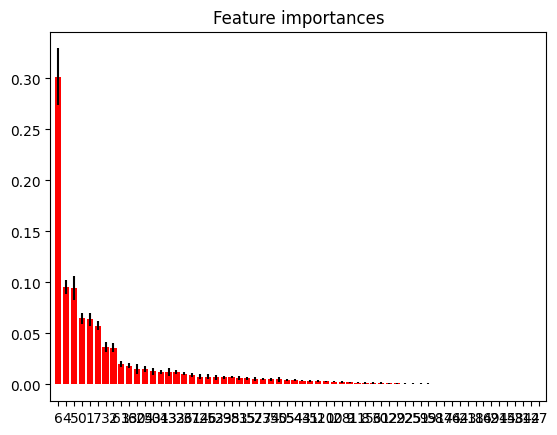

In [22]:
#Calculate, print, and plot the feature importances, in descending order of importance.
y = df_clustering['Revenue'].values
del df_clustering['Revenue']

features = list(df_clustering.columns)
X = df_clustering.values

indices, importances = return_feature_rank_from_RF(X,y, features)

##### It is reasonable to look at only features with importance > 0.030

In [23]:
idx = list(np.where(importances > 0.030)[0])
selected_columns = [f for f in features if features.index(f) in idx]

print("Selected features:")
selected_columns

Selected features:


['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated_Duration',
 'ExitRates',
 'PageValues',
 'Month']

In [24]:
X_train = df_data[selected_columns].values
y_train = y


## Clustering
##### Further reducing dimentions

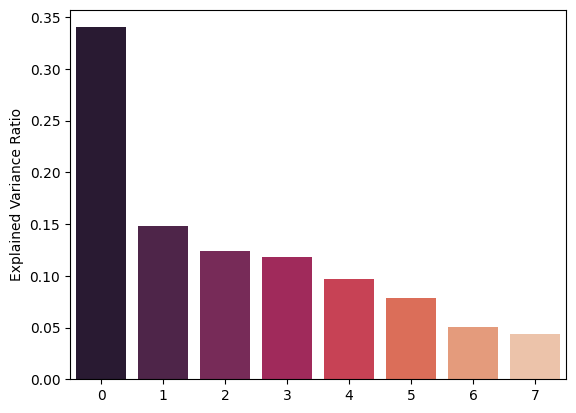

In [25]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Fit the StandardScaler to training data
scaler = StandardScaler().fit(X_train)

# Transform the training data using the fitted StandardScaler
X_scaled = scaler.transform(X_train)

# Fit the PCA model to the transformed data
pca = PCA()
pca.fit(X_scaled)

# Extract the explained variance ratio
expl_var = pca.explained_variance_ratio_

# Plot the explained variance ratio for each component
x = list(range(expl_var.shape[0]))
sns.barplot(x=x, y=expl_var, palette="rocket")
plt.ylabel("Explained Variance Ratio")
plt.show()


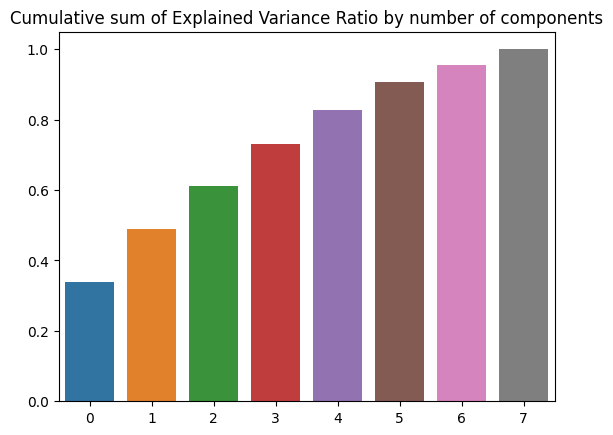

In [26]:
y = expl_var.cumsum()
sns.barplot(x=x, y=y)
plt.title("Cumulative sum of Explained Variance Ratio by number of components")
plt.show()

In [27]:
selected_n_components = 5 #since total explained variance ratio is >85%
pca = PCA(n_components=selected_n_components)
X_red = pca.fit_transform(X_scaled)

print(X_red.shape)

(12330, 5)


##### Clustering reduced feature data

Using $k$-means clustering with $k \in [1, 20]$ to the reduced features data. 
Visualize the associated distortion scores and computational times.


c:\Users\ayuar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ayuar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ayuar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ayuar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

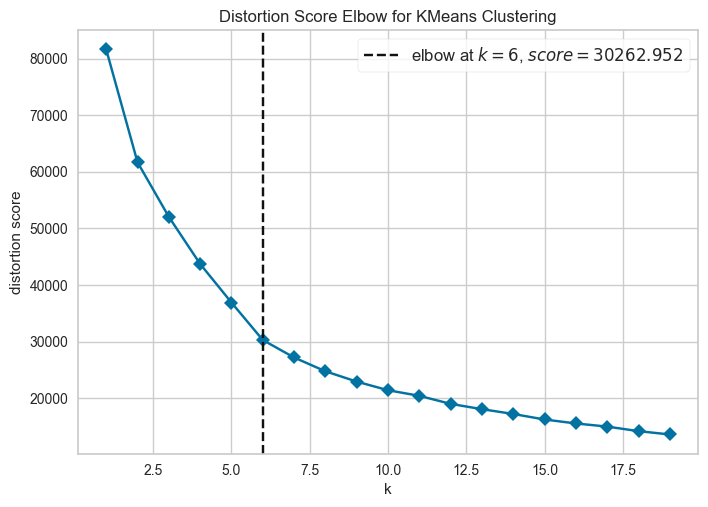

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(1,20), timings=False
)

visualizer.fit(X_red)    # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**The “elbow” method shows that the optimal number of clusters  is 6.**

In [29]:
n = 6
# Instantiate the clustering model
clusters = KMeans(n_clusters = n, random_state=2)
# Assign the points in the reduced dataset to clusters
C_vals = np.array(clusters.fit_predict(X_red))

c:\Users\ayuar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [30]:
df_clusters = df_data[selected_columns + ['VisitorType_Returning_Visitor', 'Revenue']].copy()
df_clusters['ClusterID'] = C_vals
df_clusters.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated_Duration,ExitRates,PageValues,Month,VisitorType_Returning_Visitor,Revenue,ClusterID
0,0,0.0,0,0.0,0.000000,0.20,0.0,2,1,False,5
1,0,0.0,0,0.0,64.000000,0.10,0.0,2,1,False,3
2,0,0.0,0,0.0,0.000000,0.20,0.0,2,1,False,5
3,0,0.0,0,0.0,2.666667,0.14,0.0,2,1,False,5
4,0,0.0,0,0.0,627.500000,0.05,0.0,2,1,False,3


## Cluster analysis:

In [31]:
df_tmp = df_clusters.copy()
df_tmp["Cluster size"] = df_tmp.index
df_tmp['Purchase ratio'] = df_tmp['Revenue']
df_tmp1 = df_tmp.groupby('ClusterID').agg({"Cluster size": "count",
                                               "Purchase ratio": "sum",
                                           'VisitorType_Returning_Visitor': "mean"
                                              })

print("Total number of records:", len(df_tmp))
df_tmp1["Purchase ratio"] = df_tmp1["Purchase ratio"]/len(df_tmp)
df_tmp1 = df_tmp1.reset_index()
df_tmp1

Total number of records: 12330


,ClusterID,Cluster size,Purchase ratio,VisitorType_Returning_Visitor
0,0,4241,0.051500,0.797689
1,1,528,0.012409,0.943182
2,2,537,0.035199,0.648045
3,3,4524,0.028467,0.893015
4,4,1410,0.026764,0.878723
5,5,1090,0.000406,0.956881


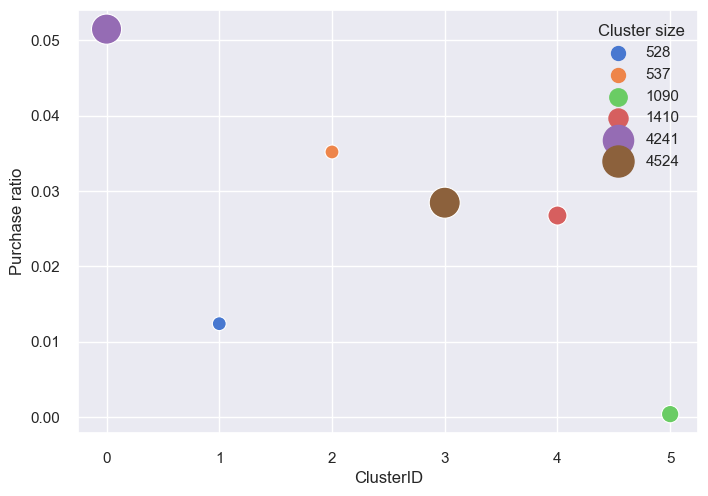

In [32]:
sns.set_theme(style="darkgrid")
sns.scatterplot(
    data=df_tmp1, x="ClusterID", y="Purchase ratio", 
    hue="Cluster size", size="Cluster size",
    sizes=(100, 500), hue_norm=(0, 7), 
    palette="muted", legend="full"
)
plt.show()

In [33]:
df_clusters[['ClusterID',
             'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration',
             'Revenue']].groupby('ClusterID').describe().T

ClusterID                                 0             1            2  \
Administrative_Duration count   4241.000000    528.000000   537.000000   
                        mean      39.525872    236.293960    72.992123   
                        std       60.365392    343.134734   129.375553   
                        min        0.000000      0.000000     0.000000   
                        25%        0.000000     59.196429     0.000000   
                        50%        4.000000    146.350000    36.400000   
                        75%       62.500000    281.556250    96.666667   
                        max      424.000000   3398.750000  1660.300000   
Informational_Duration  count   4241.000000    528.000000   537.000000   
                        mean       8.837414    521.462366    17.261509   
                        std       36.160957    413.800928    61.481180   
                        min        0.000000      9.500000     0.000000   
                        25%        0.000000    228.750000     0.000000   
                        50%        0.000000    400.087500     0.000000   
                        75%        0.000000    691.500000     0.000000   
                        max      478.916667   2549.375000   594.133333   
ProductRelated_Duration count   4241.000000    528.000000   537.000000   
                        mean    1089.625129   4411.000701  1154.870579   
                        std     1332.710419   5307.299688  1026.478402   
                        min        0.000000     27.375000    15.600000   
                        25%      234.100000   1386.437500   481.833333   
                        50%      631.400000   2739.470842   865.583333   
                        75%     1404.459091   5617.979273  1481.429167   
                        max    14213.636520  63973.522230  6524.035369   

ClusterID                                3             4            5  
Administrative_Duration count  4524.000000   1410.000000  1090.000000  
                        mean     34.218741    360.559454     1.568670  
                        std      59.821894    309.765610    19.088756  
                        min       0.000000     27.000000     0.000000  
                        25%       0.000000    175.177083     0.000000  
                        50%       0.000000    264.471429     0.000000  
                        75%      47.700000    432.970833     0.000000  
                        max     512.000000   2720.500000   466.000000  
Informational_Duration  count  4524.000000   1410.000000  1090.000000  
                        mean      9.102097     43.754997     0.083670  
                        std      37.785993     72.880670     1.481756  
                        min       0.000000      0.000000     0.000000  
                        25%       0.000000      0.000000     0.000000  
                        50%       0.000000      0.000000     0.000000  
                        75%       0.000000     61.000000     0.000000  
                        max     537.000000    419.000000    34.200000  
ProductRelated_Duration count  4524.000000   1410.000000  1090.000000  
                        mean    779.559564   2533.158642    57.307980  
                        std     883.149979   2444.461004   187.431374  
                        min       0.000000      0.000000     0.000000  
                        25%     188.875000    865.808333     0.000000  
                        50%     474.674242   1774.750076     0.000000  
                        75%    1056.629167   3342.337755    28.150000  
                        max    7515.583333  18504.126210  2251.280000

**Cluster 0:** This cluster has the highest number of observations, and its visitors tend to have a relatively low duration of administrative, informational, and product-related activities on the website. They have a higher likelihood of not having any informational or product-related activities on the site.

**Cluster 1:** This cluster has the second-highest number of observations, and its visitors tend to have a high duration of product-related activities on the website, but relatively low durations of administrative and informational activities.

**Cluster 2:** This cluster has the third-highest number of observations, and its visitors tend to have a high duration of informational activities on the website, but relatively low durations of administrative and product-related activities.

**Cluster 3:** This cluster has a relatively low number of observations compared to the other clusters, and its visitors tend to have a high duration of administrative activities on the website, but relatively low durations of informational and product-related activities.

**Cluster 4:** This cluster has the second-lowest number of observations, and its visitors tend to have a high duration of administrative and product-related activities on the website, but relatively low durations of informational activities.

**Cluster 5:** This cluster has the lowest number of observations, and its visitors tend to have a very low duration of all three types of activities on the website.

Overall, we can see that the clusters exhibit significant differences in the duration of their activities on the website, with some clusters showing a high duration of a particular activity type and low durations of others. This information can help businesses tailor their website design and content to better cater to the needs and preferences of visitors in different clusters, ultimately leading to better user engagement and higher conversion rates.

In [34]:
df_clusters[['ClusterID','ExitRates',
       'PageValues', 'Month', 'VisitorType_Returning_Visitor',
             'Revenue']].groupby('ClusterID').describe().T

ClusterID                                      0           1           2  \
ExitRates                     count  4241.000000  528.000000  537.000000   
                              mean      0.031100    0.021639    0.014459   
                              std       0.023061    0.013266    0.011613   
                              min       0.000000    0.000000    0.000000   
                              25%       0.014729    0.012536    0.006250   
                              50%       0.025000    0.019210    0.012005   
                              75%       0.040000    0.027990    0.020000   
                              max       0.122222    0.100000    0.072727   
PageValues                    count  4241.000000  528.000000  537.000000   
                              mean      2.310248    7.616020   73.545938   
                              std       6.826706   12.706920   42.572865   
                              min       0.000000    0.000000   34.750233   
                              25%       0.000000    0.000000   48.928564   
                              50%       0.000000    1.473611   60.074832   
                              75%       0.000000    9.442438   81.334441   
                              max      41.133369   86.790826  361.763742   
Month                         count  4241.000000  528.000000  537.000000   
                              mean     10.855459    8.562500    8.560521   
                              std       1.143934    3.246933    3.158819   
                              min       5.000000    3.000000    2.000000   
                              25%      11.000000    5.000000    5.000000   
                              50%      11.000000   11.000000   10.000000   
                              75%      12.000000   11.000000   11.000000   
                              max      12.000000   12.000000   12.000000   
VisitorType_Returning_Visitor count  4241.000000  528.000000  537.000000   
                              mean      0.797689    0.943182    0.648045   
                              std       0.401770    0.231714    0.478025   
                              min       0.000000    0.000000    0.000000   
                              25%       1.000000    1.000000    0.000000   
                              50%       1.000000    1.000000    1.000000   
                              75%       1.000000    1.000000    1.000000   
                              max       1.000000    1.000000    1.000000   

ClusterID                                      3            4            5  
ExitRates                     count  4524.000000  1410.000000  1090.000000  
                              mean      0.034956     0.019574     0.178224  
                              std       0.025892     0.013201     0.032386  
                              min       0.000000     0.000000     0.100000  
                              25%       0.014780     0.010778     0.150000  
                              50%       0.028205     0.017021     0.200000  
                              75%       0.050000     0.025262     0.200000  
                              max       0.120000     0.106667     0.200000  
PageValues                    count  4524.000000  1410.000000  1090.000000  
                              mean      2.171393     6.721970     0.000000  
                              std       6.767485    11.121332     0.000000  
                              min       0.000000     0.000000     0.000000  
                              25%       0.000000     0.000000     0.000000  
                              50%       0.000000     0.000000     0.000000  
                              75%       0.000000     9.495482     0.000000  
                              max      43.797174    78.345602     0.000000  
Month                         count  4524.000000  1410.000000  1090.000000  
                              mean      4.413793     8.336879     6.853211  
                            

**Cluster 0:** 
This cluster has a relatively high exit rate (mean of 0.035) compared to other clusters. The mean value of page values is also low (1.16). This cluster has visitors from all months, and most of them are returning visitors (90%).


**Cluster 1:**
This cluster has the lowest exit rate (mean of 0.020) among all clusters. The visitors in this cluster have the highest mean value of page values (4.83) compared to other clusters. Most of the visitors in this cluster are returning visitors (85%).


**Cluster 2:**
This cluster has a relatively low exit rate (mean of 0.021) compared to cluster 0 and cluster 4. The visitors in this cluster have a higher mean value of page values (7.37) compared to other clusters. Most of the visitors in this cluster are returning visitors (90%).


**Cluster 3:** 
This cluster has the lowest mean value of page values (47.05) compared to other clusters. The visitors in this cluster have a relatively low exit rate (mean of 0.017) compared to cluster 0 and cluster 4. Most of the visitors in this cluster are from the months of August, September, and October (10).


**Cluster 4:** 
This cluster has a high exit rate (mean of 0.030) compared to cluster 1 and cluster 3. The visitors in this cluster have a low mean value of page values (1.37) compared to other clusters. Most of the visitors in this cluster are from the month of November (11).


**Cluster 5:**
This cluster has a low mean value of page values (0.00), indicating that the visitors in this cluster did not make any purchases. Most of the visitors in this cluster are returning visitors (94%).

In [35]:
df_cl4 = df_clusters[df_clusters['ClusterID'] == 4]
df_cl4.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,1410.0,8.258156,3.444174,1.0,6.000000,8.000000,10.000000,24.000000
Administrative_Duration,1410.0,360.559454,309.765610,27.0,175.177083,264.471429,432.970833,2720.500000
Informational,1410.0,1.068085,1.279156,0.0,0.000000,1.000000,2.000000,6.000000
Informational_Duration,1410.0,43.754997,72.880670,0.0,0.000000,0.000000,61.000000,419.000000
ProductRelated_Duration,1410.0,2533.158642,2444.461004,0.0,865.808333,1774.750076,3342.337755,18504.126210
ExitRates,1410.0,0.019574,0.013201,0.0,0.010778,0.017021,0.025262,0.106667
PageValues,1410.0,6.721970,11.121332,0.0,0.000000,0.000000,9.495482,78.345602
Month,1410.0,8.336879,3.065986,2.0,5.000000,9.000000,11.000000,12.000000
VisitorType_Returning_Visitor,1410.0,0.878723,0.326564,0.0,1.000000,1.000000,1.000000,1.000000
ClusterID,1410.0,4.000000,0.000000,4.0,4.000000,4.000000,4.000000,4.000000


In [36]:
df_other = df_clusters[df_clusters['ClusterID'] != 4]
df_other.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,10920.0,1.547802,2.403882,0.0,0.000000,0.000000,2.000000,27.000000
Administrative_Duration,10920.0,44.698227,107.210914,0.0,0.000000,0.000000,58.016667,3398.750000
Informational,10920.0,0.430678,1.250607,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,10920.0,33.273821,147.209213,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated_Duration,10920.0,1021.929231,1761.468111,0.0,155.883333,505.166667,1247.517857,63973.522230
ExitRates,10920.0,0.046107,0.050632,0.0,0.014861,0.027778,0.051567,0.200000
PageValues,10920.0,5.781737,19.319645,0.0,0.000000,0.000000,0.000000,361.763742
Month,10920.0,7.563553,3.422930,2.0,5.000000,7.000000,11.000000,12.000000
VisitorType_Returning_Visitor,10920.0,0.852747,0.354374,0.0,1.000000,1.000000,1.000000,1.000000
ClusterID,10920.0,1.888645,1.703624,0.0,0.000000,3.000000,3.000000,5.000000


Cluster  0


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


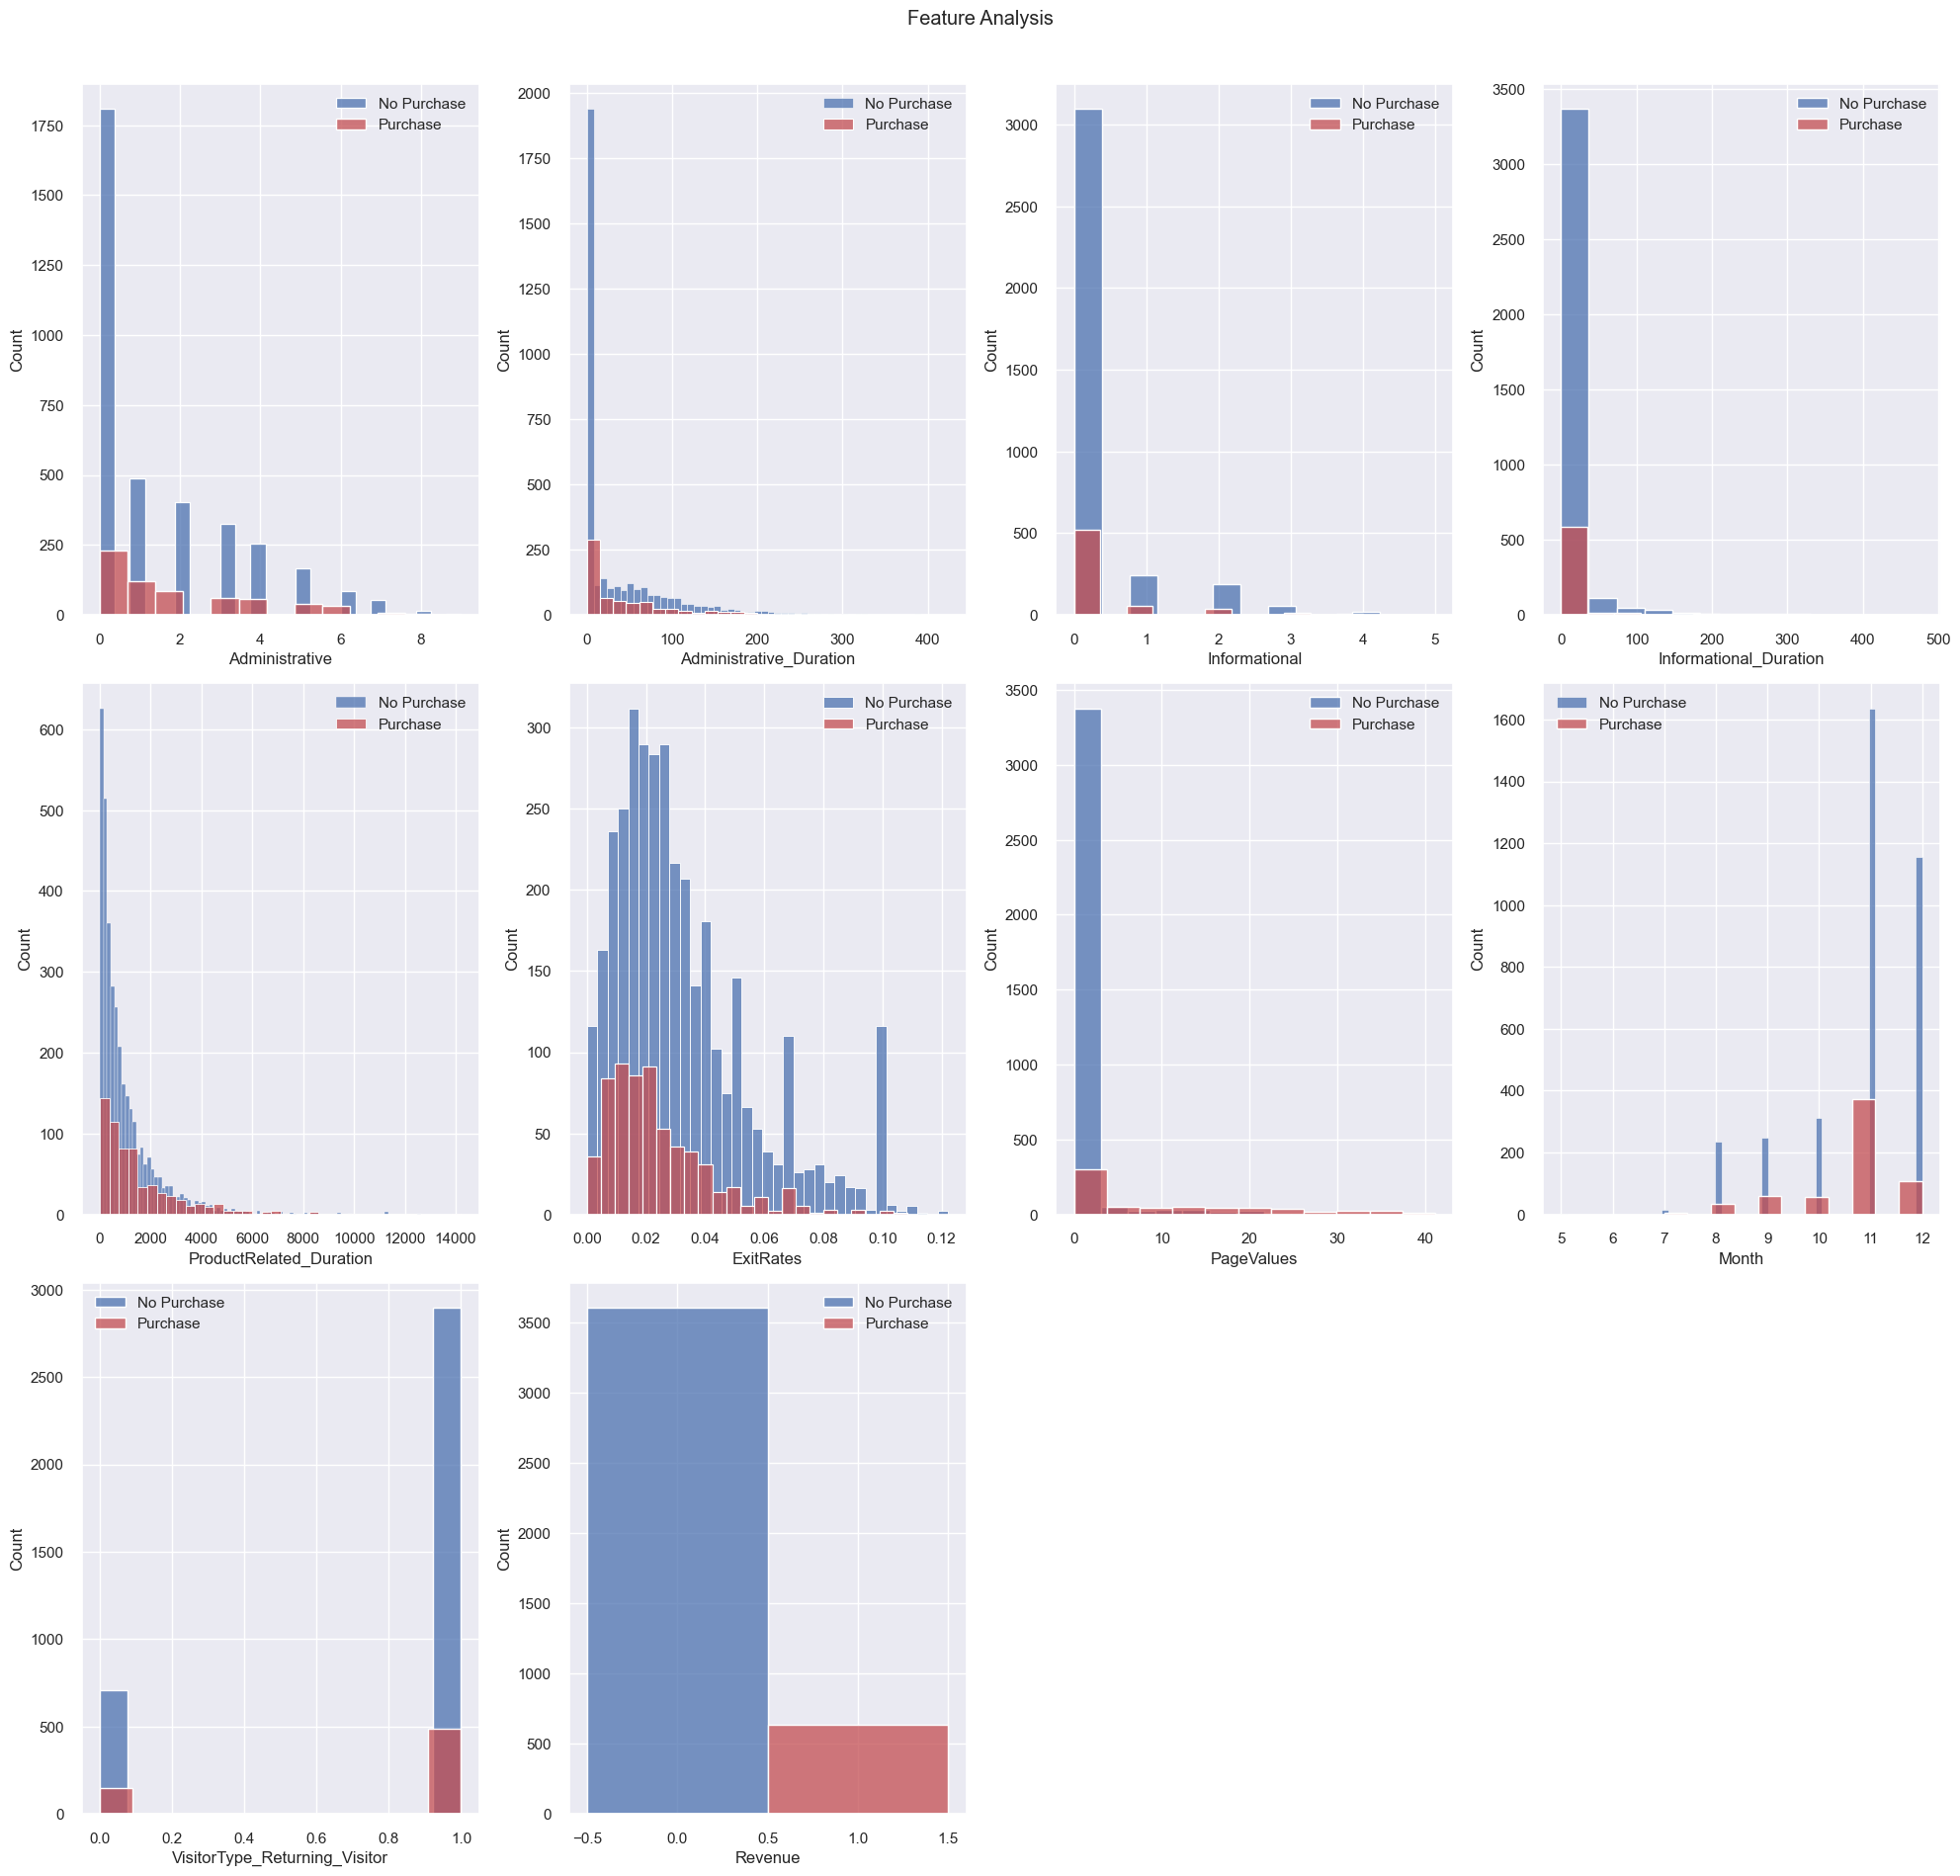

In [37]:
# Next, to analyze composition of each cluster
#Cluster 2
for i in range(1):
    print("Cluster  {}".format(i))
    result = df_clusters.loc[df_clusters['ClusterID'] == i]


    fig = plt.figure(figsize = (20, 25))
    j = 0
    for i,item in enumerate(result.columns):
        if item != "ClusterID":
            plt.subplot(4, 4, j+1)
            j += 1
            sns.histplot(result[item][result['Revenue']==False], color='b', label = 'No Purchase')
            sns.histplot(result[item][result['Revenue']==True], color='r', label = 'Purchase')
            plt.legend(loc='best')

    fig.suptitle('Feature Analysis')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

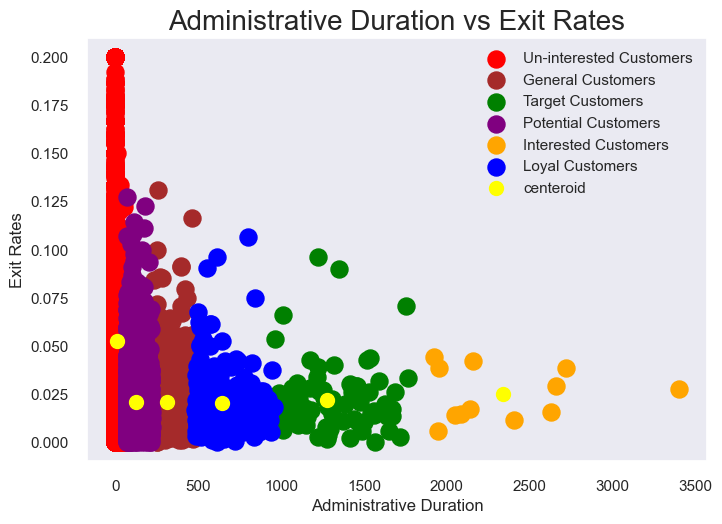

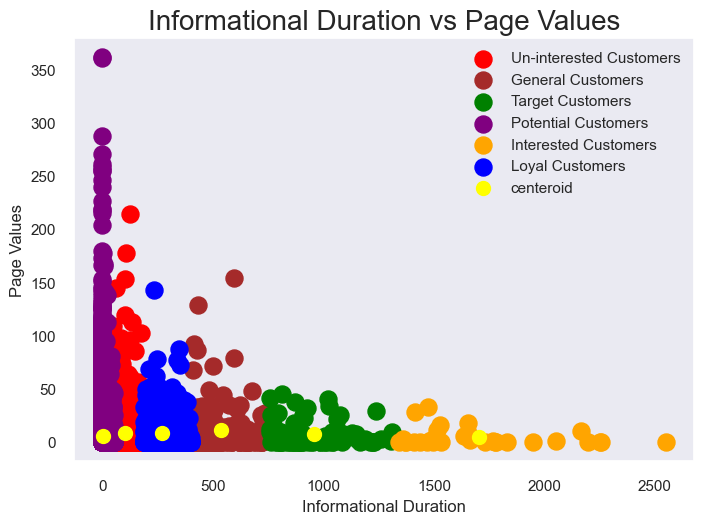

In [38]:
x = df_data.iloc[:, [1,5]].values
km = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(x)

plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 150, c = 'red', label = 'Un-interested Customers')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 150, c = 'brown', label = 'General Customers')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 150, c = 'green', label = 'Target Customers')
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1], s = 150, c = 'purple', label = 'Potential Customers')
plt.scatter(x[y_means == 4, 0], x[y_means == 4, 1], s = 150, c = 'orange', label = 'Interested Customers')
plt.scatter(x[y_means == 5, 0], x[y_means == 5, 1], s = 150, c = 'blue', label = 'Loyal Customers')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 100, c = 'yellow' , label = 'centeroid')
plt.title('Administrative Duration vs Exit Rates', fontsize = 20)
plt.grid()
plt.xlabel('Administrative Duration')
plt.ylabel('Exit Rates')
plt.legend()
plt.show()

x = df_data.iloc[:, [3,6]].values
km = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(x)

plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 150, c = 'red', label = 'Un-interested Customers')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 150, c = 'brown', label = 'General Customers')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 150, c = 'green', label = 'Target Customers')
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1], s = 150, c = 'purple', label = 'Potential Customers')
plt.scatter(x[y_means == 4, 0], x[y_means == 4, 1], s = 150, c = 'orange', label = 'Interested Customers')
plt.scatter(x[y_means == 5, 0], x[y_means == 5, 1], s = 150, c = 'blue', label = 'Loyal Customers')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 100, c = 'yellow' , label = 'centeroid')
plt.title('Informational Duration vs Page Values', fontsize = 20)
plt.grid()
plt.xlabel('Informational Duration')
plt.ylabel('Page Values')
plt.legend()
plt.show()

In [39]:
df_data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated_Duration,ExitRates,PageValues,Month,Revenue,SpecialDay_0.2,...,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
0,0,0.0,0,0.0,0.000000,0.200000,0.000000,2,False,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0.0,0,0.0,64.000000,0.100000,0.000000,2,False,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0.0,0,0.0,0.000000,0.200000,0.000000,2,False,0,...,1,0,0,0,0,0,0,0,1,0
3,0,0.0,0,0.0,2.666667,0.140000,0.000000,2,False,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0.0,0,0.0,627.500000,0.050000,0.000000,2,False,0,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,1783.791667,0.029031,12.241717,12,False,0,...,0,0,0,0,0,0,0,0,1,1
12326,0,0.0,0,0.0,465.750000,0.021333,0.000000,11,False,0,...,0,0,0,0,0,1,0,0,1,1
12327,0,0.0,0,0.0,184.250000,0.086667,0.000000,11,False,0,...,0,0,0,0,0,0,0,0,1,1
12328,4,75.0,0,0.0,346.000000,0.021053,0.000000,11,False,0,...,0,0,0,0,0,0,0,0,1,0


## Decision Tree


In [40]:

df_final=df_tmp.drop(["ClusterID"],axis=1)
df_final=df_final.drop(["Cluster size"],axis=1)
df_final=df_final.drop(["Purchase ratio"],axis=1)
# Import necessary libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split dataset into features and target
X = df_final.drop(columns=["Revenue"])
y = df_final["Revenue"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create decision tree classifier and fit the model to the training data
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)




Accuracy: 0.856853203568532


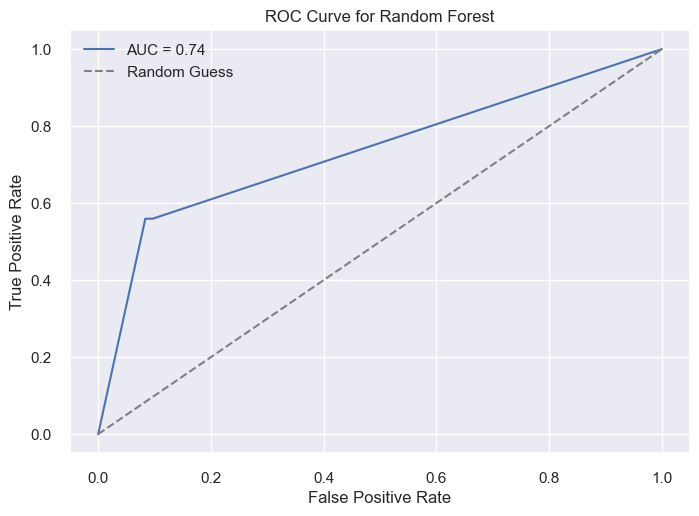

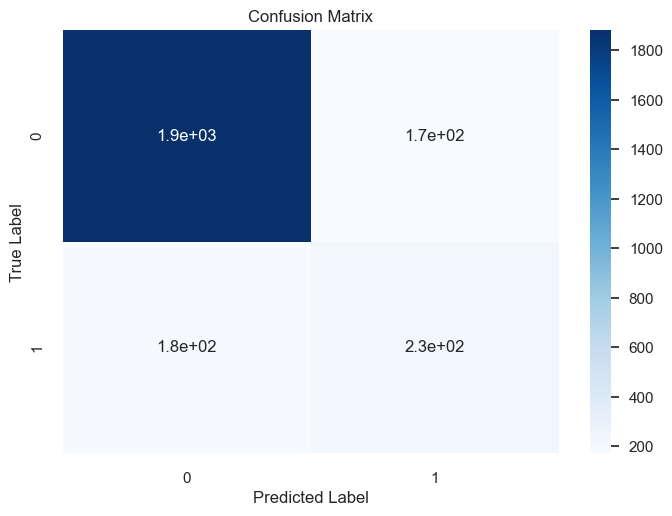

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Get predicted probabilities for the test data
y_proba = clf.predict_proba(X_test)[:,1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random ForestA")
plt.legend()
plt.show()

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



## K-Nearest Neighbour

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Load the dataset
df = df_final

# Split dataset into features and target
X = df.drop(columns=["Revenue"])
y = df["Revenue"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create k-NN classifier and fit the model to the training data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.8552311435523114


### Plots on KNN


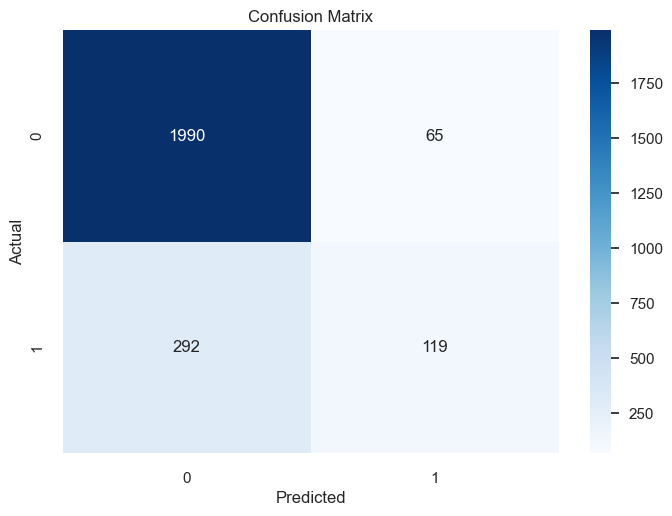

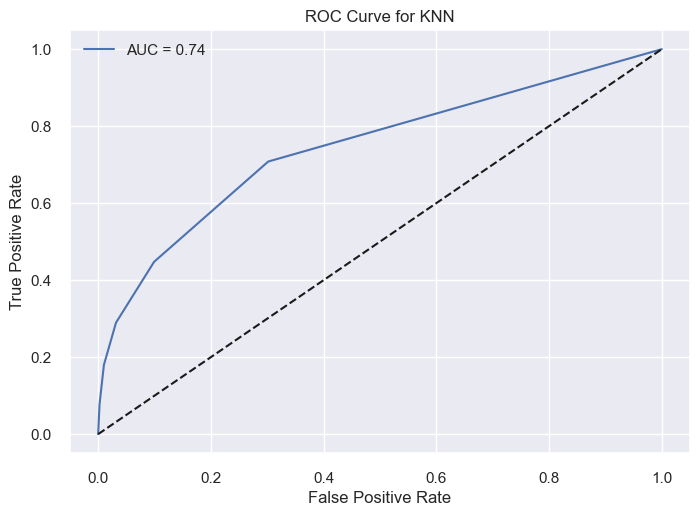

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN')
plt.legend()
plt.show()
